In [1]:
# DART

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import missingno as msno
import pickle
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xg
from sklearn.metrics import mean_squared_error

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',1000)

import warnings
warnings.filterwarnings("ignore")

In [3]:
target_variable = 'forcedFumble'
OVERSAMPLE_FLAG = True

df = pd.read_csv('../data/processed/TRAINING_SAMPLE_ML_Dataset.csv').drop('Unnamed: 0',axis=1)
df = df.drop(['SAMP_gameId','SAMP_playId','event','possessionTeam','CLOSEST_OPP_ID'],axis=1)
df = df[df['OFF_DEF_FLAG']=='DEF'].reset_index().drop(['index','OFF_DEF_FLAG'],axis=1)

# Dummify Categoricals
dummy_parent_cols = ['position', 'offenseFormation']
dummy_child_cols = ['position_CB','position_DB','position_DE','position_DT','position_FS','position_ILB',
                    'position_MLB','position_NT','position_OLB','position_SS','offenseFormation_EMPTY',
                    'offenseFormation_I_FORM','offenseFormation_JUMBO','offenseFormation_PISTOL',
                    'offenseFormation_SHOTGUN','offenseFormation_SINGLEBACK','offenseFormation_WILDCAT']

pbar = tqdm(total=len(dummy_child_cols))
for col in dummy_child_cols:
    for prnt_col in dummy_parent_cols:
        if prnt_col in col:
            for idx,row in df.iterrows():
                if row[prnt_col] == str(col.split('_')[1]):
                    df.at[idx,col] = 1
                else:
                    df.at[idx,col] = 0
    pbar.update(1)
pbar.close()
                    
df = df.drop(dummy_parent_cols,axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [18:55<00:00, 66.77s/it]


In [4]:
df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,weight,height,defendersInTheBox,YardsFromScoring,quarter,down,yardsToGo,Stadium_Domed,Stadium_Turfed,Kickoff_temp,Kickoff_dwpt,Kickoff_rhum,Kickoff_prcp,Kickoff_snow,Kickoff_wdir,Kickoff_wspd,Kickoff_pres,DISTANCE_TO_CLOSEST_OPP,DEF_ORIENTATION,ENGAGED_IN_BLOCK,DISTANCE_TO_BALL,OPEN_PATH_TO_BALL,FREE_BLOCKER_W_BALL_CARRIER_FLAG,tackle,assist,forcedFumble,pff_missedTackle,position_CB,position_DB,position_DE,position_DT,position_FS,position_ILB,position_MLB,position_NT,position_OLB,position_SS,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,2022090800,101,38577.0,Bobby Wagner,1,2022-09-08 20:25:08.200000,45.0,LA,left,67.32,29.83,0.07,0.05,0.01,71.08,146.58,242.0,72.0,6.0,62.0,1,1,10,1,1,27.8,16.1,49.0,0.0,NaN,90.0,11.2,1012.2,5.193197,273.23,0.0,4.719543,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022090800,101,38577.0,Bobby Wagner,2,2022-09-08 20:25:08.299999,45.0,LA,left,67.32,29.84,0.03,0.03,0.02,70.42,134.80,242.0,72.0,6.0,62.0,1,1,10,1,1,27.8,16.1,49.0,0.0,NaN,90.0,11.2,1012.2,5.193197,273.23,0.0,4.720189,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022090800,101,38577.0,Bobby Wagner,3,2022-09-08 20:25:08.400000,45.0,LA,left,67.32,29.86,0.02,0.03,0.01,70.42,102.66,242.0,72.0,6.0,62.0,1,1,10,1,1,27.8,16.1,49.0,0.0,NaN,90.0,11.2,1012.2,5.204633,273.23,0.0,4.721545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022090800,101,38577.0,Bobby Wagner,4,2022-09-08 20:25:08.500000,45.0,LA,left,67.33,29.89,0.04,0.03,0.04,70.42,46.38,242.0,72.0,6.0,62.0,1,1,10,1,1,27.8,16.1,49.0,0.0,NaN,90.0,11.2,1012.2,5.196999,273.23,0.0,4.713766,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022090800,101,38577.0,Bobby Wagner,5,2022-09-08 20:25:08.599999,45.0,LA,left,67.35,29.92,0.06,0.05,0.03,70.42,37.25,242.0,72.0,6.0,62.0,1,1,10,1,1,27.8,16.1,49.0,0.0,NaN,90.0,11.2,1012.2,5.170503,273.23,0.0,4.707028,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# INFO DF
info_df = df[['gameId','playId','nflId','displayName','frameId','time','jerseyNumber','club','x','y','s','a','dis','o',
              'dir','tackle','assist','forcedFumble','pff_missedTackle']]

# Target DF
y = df[target_variable]

X = df.drop(['gameId','playId','nflId','displayName','frameId','time','jerseyNumber','club',
             'tackle','assist','forcedFumble','pff_missedTackle','playDirection'],axis=1)

assert X.columns.tolist() == ['x','y','s','a','dis','o','dir','weight','height','defendersInTheBox','YardsFromScoring',
                              'quarter','down','yardsToGo','Stadium_Domed','Stadium_Turfed','Kickoff_temp',
                              'Kickoff_dwpt','Kickoff_rhum','Kickoff_prcp','Kickoff_snow','Kickoff_wdir',
                              'Kickoff_wspd','Kickoff_pres','DISTANCE_TO_CLOSEST_OPP','DEF_ORIENTATION',
                              'ENGAGED_IN_BLOCK','DISTANCE_TO_BALL','OPEN_PATH_TO_BALL',
                              'FREE_BLOCKER_W_BALL_CARRIER_FLAG','position_CB','position_DB','position_DE',
                              'position_DT','position_FS','position_ILB','position_MLB','position_NT','position_OLB',
                              'position_SS','offenseFormation_EMPTY','offenseFormation_I_FORM',
                              'offenseFormation_JUMBO','offenseFormation_PISTOL','offenseFormation_SHOTGUN',
                              'offenseFormation_SINGLEBACK','offenseFormation_WILDCAT'], f"ERROR - X.columns doesn't match expected values"

In [6]:
# OverSampling
if OVERSAMPLE_FLAG:
    oversample = RandomOverSampler(sampling_strategy=0.5)
    X, y = oversample.fit_resample(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=69)

print(f"Training: {len(X_train)} Rows")
print(f"Testing: {len(X_test)} Rows")

Training: 1130829 Rows
Testing: 161548 Rows


In [8]:
# XGBoost Model
param_grid = {'booster':['gbtree'],
             'learning_rate':[0.001, 0.01, 0.1, 1.0, 10],
             'min_split_loss':[0.001, 0.01, 0.1, 1.0, 10],
             'max_depth':[5, 7, 9, 11],
             'reg_lambda':[0.001, 0.01, 0.1, 1.0, 10],
             'reg_alpha':[0.001, 0.01, 0.1, 1.0, 10],
             'max_leaves':[64,128, 256]}

my_val = 1
for k,v in param_grid.items():
    my_val = my_val*len(v)
    
print(f"Fitting {my_val} Iterations Of Grid HyperParameters\n")

xgb = xg.XGBClassifier()

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train, y_train)

# print('gbtree - best_params_')
# grid_search.best_params_

Fitting 7500 Iterations Of Grid HyperParameters



In [9]:
# XGBoost Model
param_grid = {'booster':['dart'],
              'sample_type':['uniform','weighted'],
              'normalize_type':['tree','forest'],
              'rate_drop':[0.05, 0.25, 0.5],
              'one_drop':[0, 1],
              'skip_drop':[0.01, 0.05, 0.1]}

my_val = 1
for k,v in param_grid.items():
    my_val = my_val*len(v)
    
print(f"Fitting {my_val} Iterations Of Grid HyperParameters\n")

xgb = xg.XGBClassifier()

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train, y_train)

# print('dart - best_params_')
# grid_search.best_params_

Fitting 72 Iterations Of Grid HyperParameters



In [10]:
xgb = xg.XGBClassifier(booster = 'gbtree',
                     learning_rate = 0.01,
                     min_split_loss = 0.01,
                     max_depth = 5,
                     reg_lambda = 1.0,
                     reg_alpha = 0.01,
                     max_leaves = 64)

xgb.fit(X_train,y_train)


print(f"gbtree - Training Score: {xgb.score(X_train,y_train)}")
print(f"gbtree - Testing Score: {xgb.score(X_test,y_test)}")



xgb2 = xg.XGBClassifier(booster = 'dart',
                         normalize_type = 'tree',
                         one_drop = 0,
                         rate_drop = 0.25,
                         sample_type = 'weighted',
                         skip_drop = 0.05)

xgb2.fit(X_train,y_train)


print(f"dart - Training Score: {xgb2.score(X_train,y_train)}")
print(f"dart - Testing Score: {xgb2.score(X_test,y_test)}")

gbtree - Training Score: 0.9719338644481172
gbtree - Testing Score: 0.9723178250427118
dart - Training Score: 0.9926788223506825
dart - Testing Score: 0.9927080496199272


In [11]:
filename = f'../models/XGBtree_NFL_BDB_FORCED_FUMBLE_MODEL.sav'
pickle.dump(xgb, open(filename, 'wb'))

filename = f'../models/XGBdart_NFL_BDB_FORCED_FUMBLE_MODEL.sav'
pickle.dump(xgb2, open(filename, 'wb'))

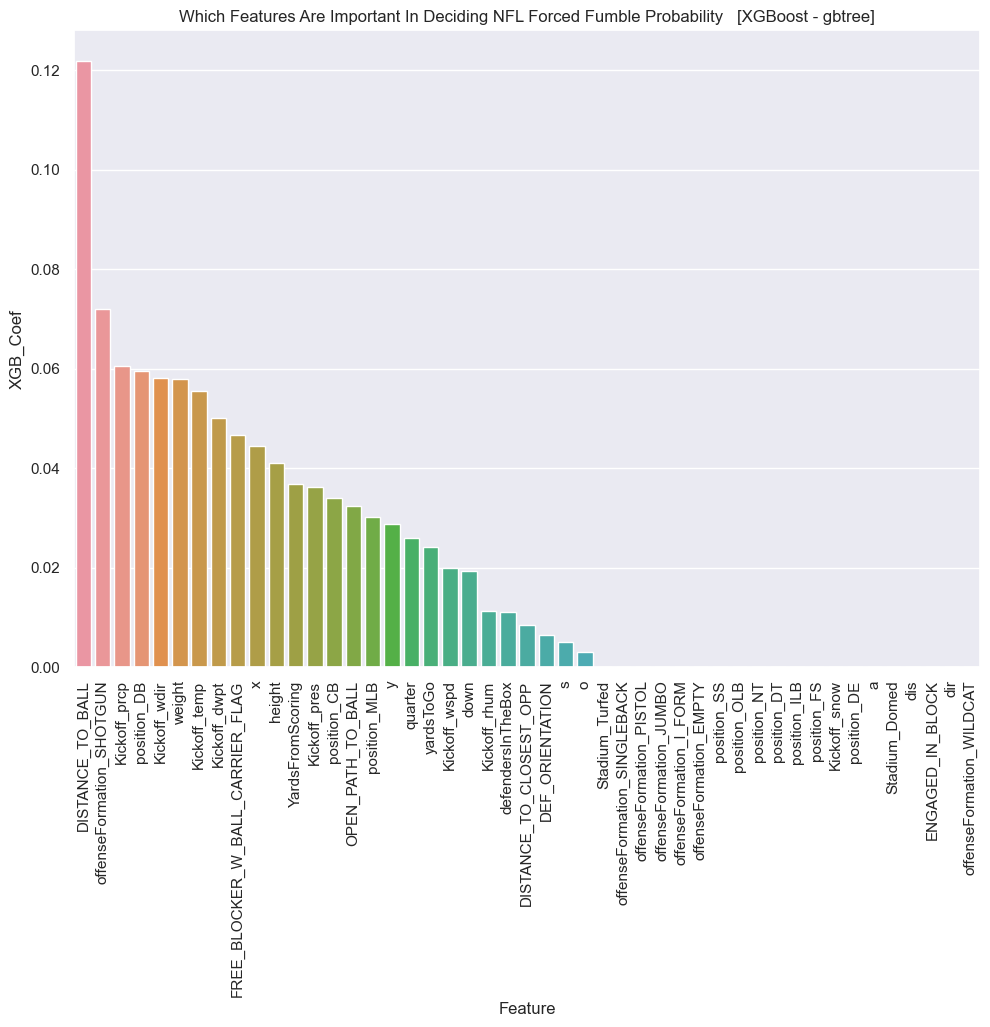

In [12]:
# Feature Importance sns Plot
importances = xgb.feature_importances_.tolist()
_feat_imp_df = pd.DataFrame(data = [X.columns.tolist(),importances])
_feat_imp_df = _feat_imp_df.T
_feat_imp_df.columns=['Feature','XGB_Coef']
_feat_imp_df = _feat_imp_df.sort_values(by='XGB_Coef',ascending=False).reset_index().drop('index',axis=1)
_feat_imp_df = _feat_imp_df.dropna()
#_feat_imp_df = _feat_imp_df[_feat_imp_df['XGB_Coef']>_feat_imp_df['XGB_Coef'].mean()].reset_index().drop('index',axis=1)

import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.barplot(data=_feat_imp_df,x="Feature",y='XGB_Coef')
g.set_xticklabels(labels=_feat_imp_df["Feature"].tolist(), rotation=90)
g.set(title='Which Features Are Important In Deciding NFL Forced Fumble Probability   [XGBoost - gbtree]');

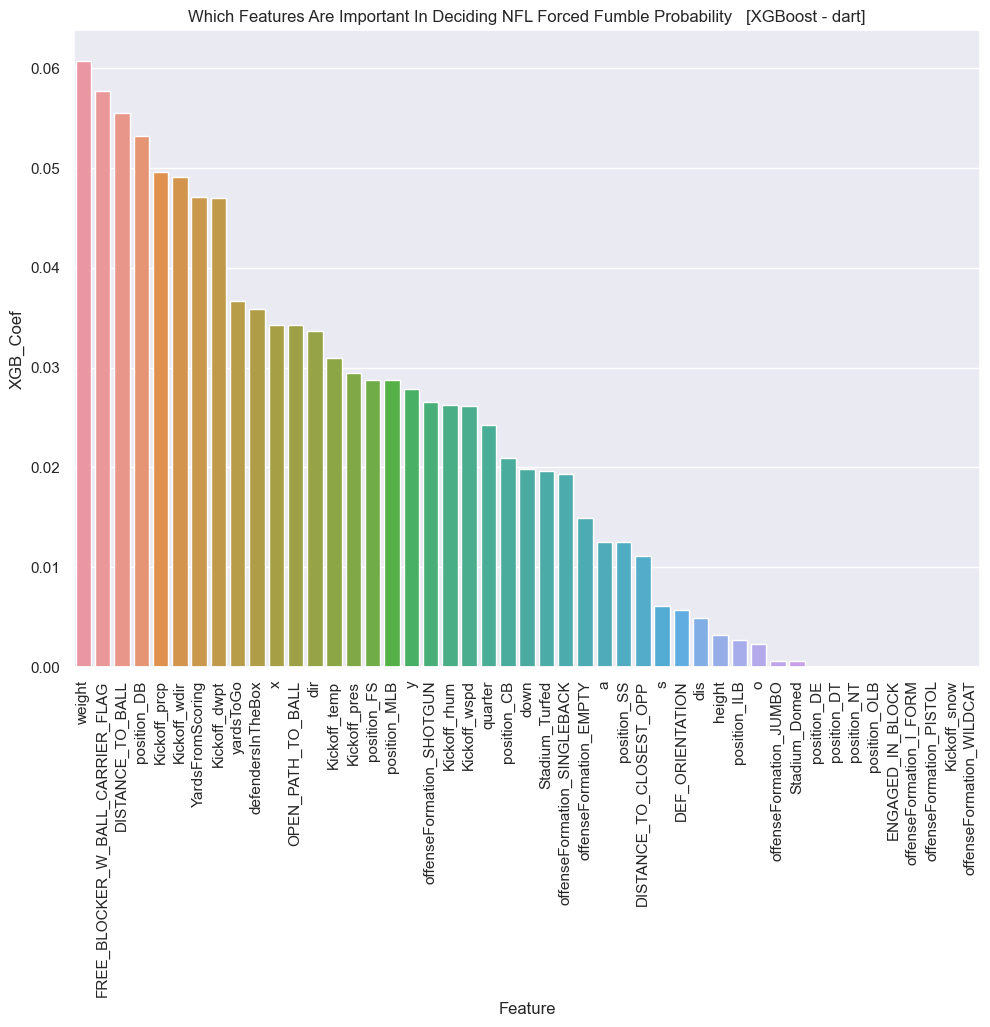

In [13]:
# Feature Importance sns Plot
importances = xgb2.feature_importances_.tolist()
_feat_imp_df = pd.DataFrame(data = [X.columns.tolist(),importances])
_feat_imp_df = _feat_imp_df.T
_feat_imp_df.columns=['Feature','XGB_Coef']
_feat_imp_df = _feat_imp_df.sort_values(by='XGB_Coef',ascending=False).reset_index().drop('index',axis=1)
_feat_imp_df = _feat_imp_df.dropna()
#_feat_imp_df = _feat_imp_df[_feat_imp_df['XGB_Coef']>_feat_imp_df['XGB_Coef'].mean()].reset_index().drop('index',axis=1)

import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.barplot(data=_feat_imp_df,x="Feature",y='XGB_Coef')
g.set_xticklabels(labels=_feat_imp_df["Feature"].tolist(), rotation=90)
g.set(title='Which Features Are Important In Deciding NFL Forced Fumble Probability   [XGBoost - dart]');

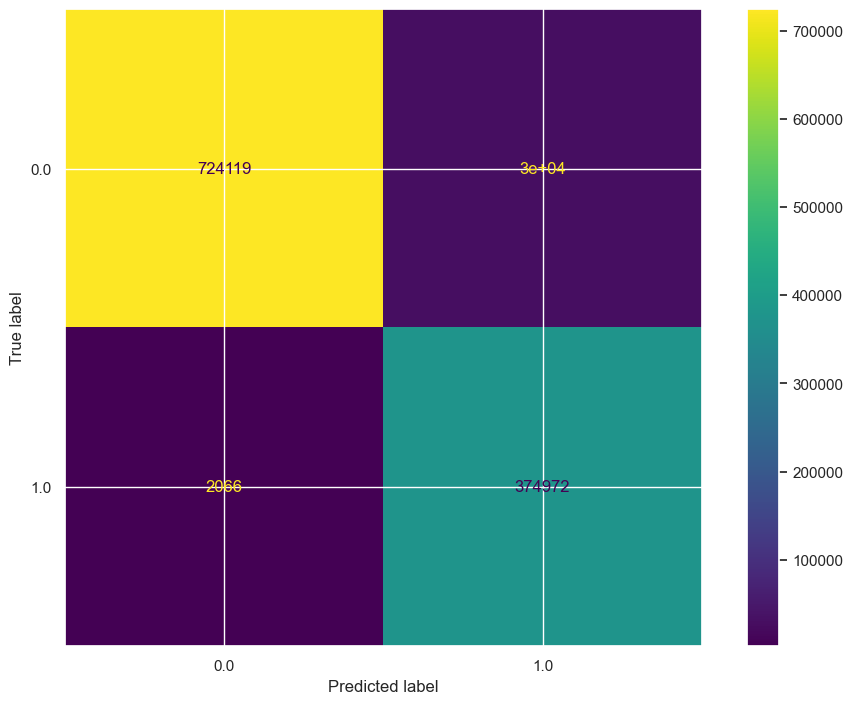

In [14]:
# Confusion Matrix
plot_confusion_matrix(xgb, X_train, y_train)  
plt.show()

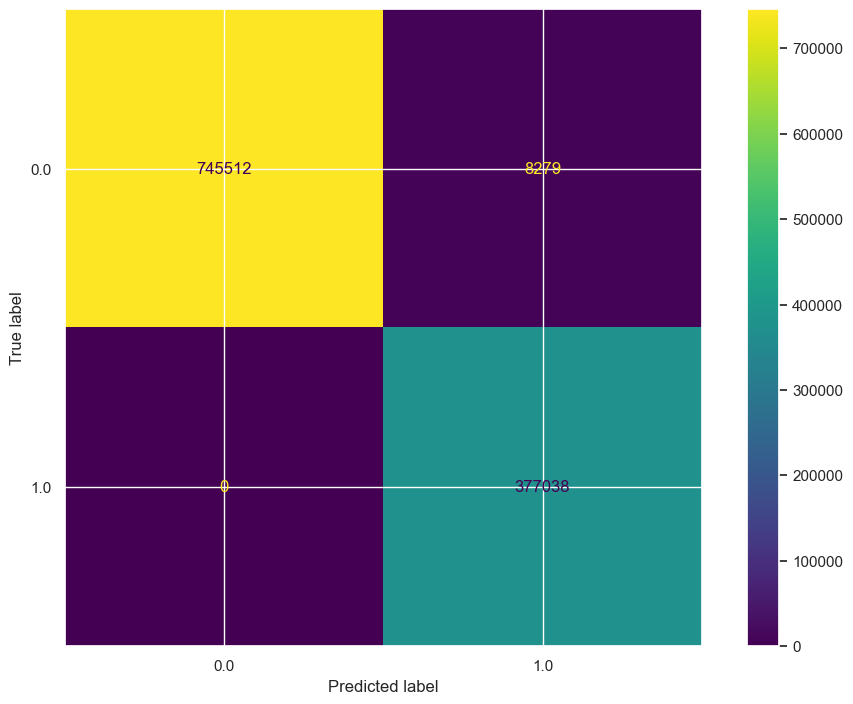

In [15]:
# Confusion Matrix
plot_confusion_matrix(xgb2, X_train, y_train)  
plt.show()

In [16]:
# Accuracy Report Of Best Model
y_pred = xgb.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    107794
         1.0       0.93      0.99      0.96     53754

    accuracy                           0.97    161548
   macro avg       0.96      0.98      0.97    161548
weighted avg       0.97      0.97      0.97    161548



In [17]:
# Accuracy Report Of Best Model
y_pred = xgb2.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    107794
         1.0       0.98      1.00      0.99     53754

    accuracy                           0.99    161548
   macro avg       0.99      0.99      0.99    161548
weighted avg       0.99      0.99      0.99    161548



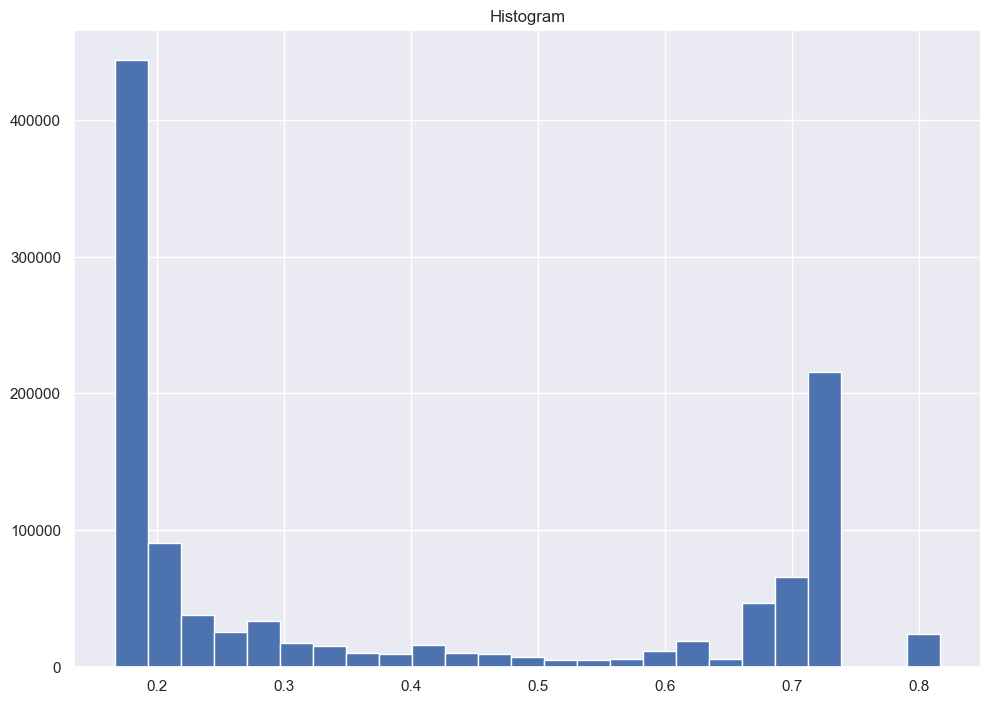

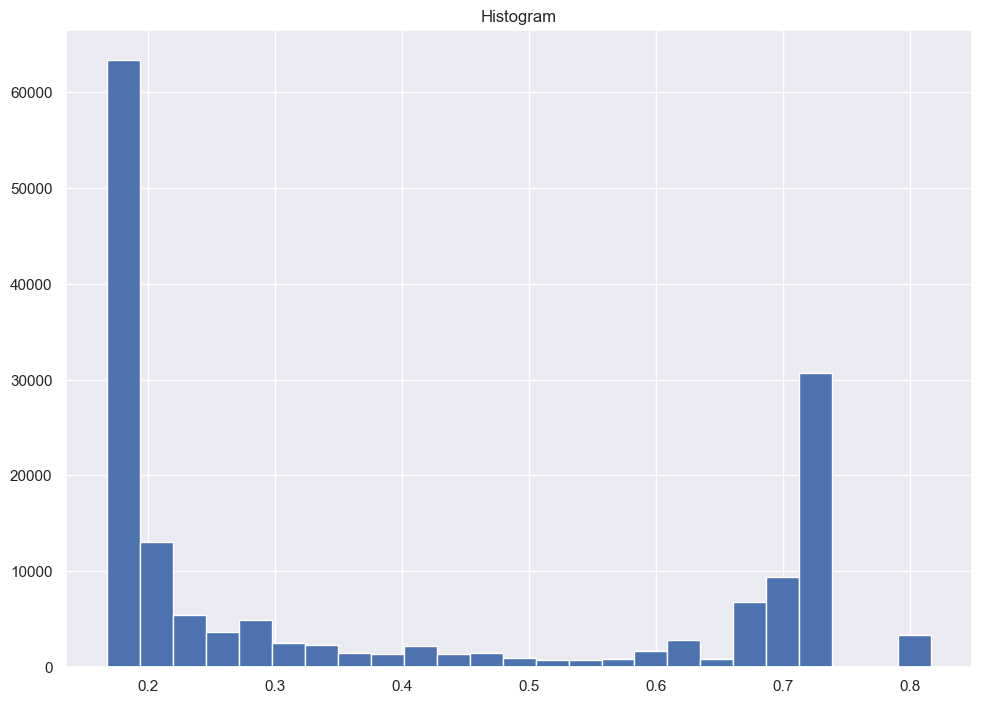

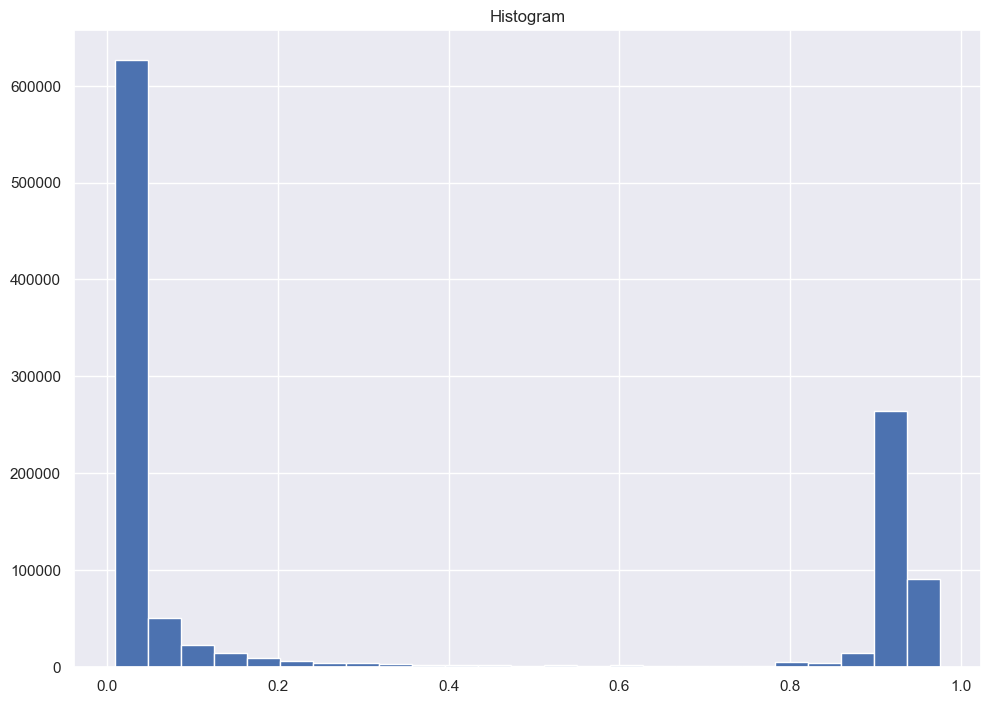

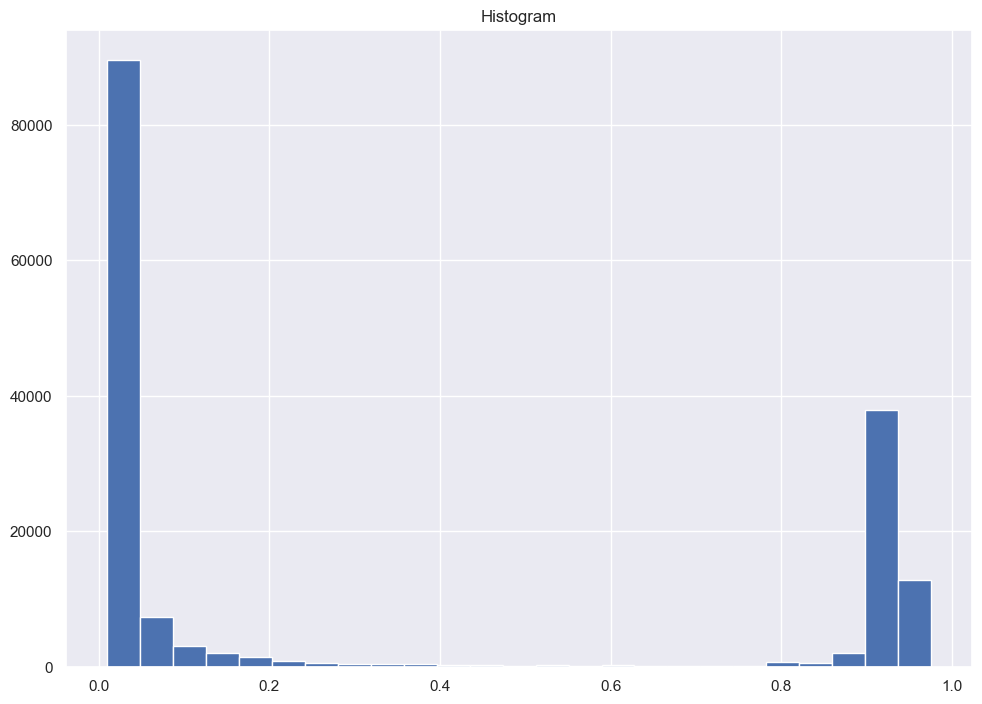

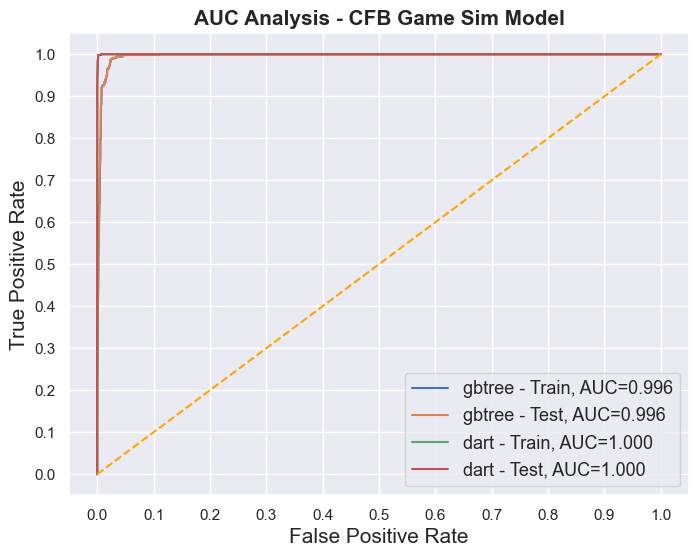

In [18]:
# ROC/AUC
#####################################
# AUC Plot
classifiers = [xgb, xgb, xgb2, xgb2]

X_tests = [X_train, X_test, X_train, X_test]

y_tests = [y_train, y_test, y_train, y_test]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['fpr','tpr','auc'])

# Train the models and record the results
i=0
for cls in classifiers:
    yproba = cls.predict_proba(X_tests[i])[::,1]
    
    _ = plt.hist(yproba, bins=25)  # arguments are passed to np.histogram
    plt.title("Histogram")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_tests[i],  yproba)
    auc = roc_auc_score(y_tests[i], yproba)
    
    result_table.loc[len(result_table.index)] = [fpr, tpr, auc]
    
    i=i+1
    
    

result_table['classifiers'] = ['gbtree - Train', 'gbtree - Test', 'dart - Train', 'dart - Test']

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('AUC Analysis - CFB Game Sim Model', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()